In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
calendar_data = pd.read_csv('../data/shop_sales_dates.csv')
calendar_data['date'] = pd.to_datetime(calendar_data['date'])
calendar_data['event'] = calendar_data['event_name_1'].combine_first(calendar_data['event_name_2'])
holidays_data = calendar_data.dropna(subset=['event'])
holidays = holidays_data[['date', 'event']]
holidays = holidays.rename(columns={'date': 'ds', 'event': 'holiday'})
holidays

,ds,holiday
8,2011-02-06,SuperBowl
16,2011-02-14,ValentinesDay
23,2011-02-21,PresidentsDay
39,2011-03-09,LentStart
46,2011-03-16,LentWeek2
...,...,...
1780,2015-12-14,Chanukah End
1791,2015-12-25,Christmas
1798,2016-01-01,NewYear
1804,2016-01-07,OrthodoxChristmas


In [3]:
data = pd.read_csv('../data/joined_data.csv')
data['date'] = pd.to_datetime(data['date'])

store_id = 'STORE_2'
art = '_085'
df=data[(data.item_id==store_id + art) & (data.store_id==store_id)].copy()
df.head()

,date,wday,month,date_id,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3,item_id,store_id,cnt,sell_price,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend
0,2011-01-29,1,1,1,0,0,0,STORE_2_085,STORE_2,3,1.0,0,0,0,0,1
45,2011-01-30,2,1,2,0,0,0,STORE_2_085,STORE_2,8,1.0,0,0,0,0,1
90,2011-01-31,3,1,3,0,0,0,STORE_2_085,STORE_2,0,1.0,0,0,0,0,0
135,2011-02-01,4,2,4,0,1,1,STORE_2_085,STORE_2,3,1.0,0,0,0,0,0
180,2011-02-02,5,2,5,1,1,0,STORE_2_085,STORE_2,0,1.0,0,0,0,0,0


In [4]:
columns_to_remove = ['item_id',
                     "store_id",
                     'date_id',]
df.drop(axis=1, columns=columns_to_remove, inplace=True)
# df = df[['date', 'cnt']]
# df['holiday'] = df['event_type_1'].apply(lambda x: 0 if pd.isna(x) else 1)
df.set_index('date', inplace=True)
df.head(10)

,wday,month,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3,cnt,sell_price,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend
date,,,,,,,,,,,,
2011-01-29,1,1,0,0,0,3,1.0,0,0,0,0,1
2011-01-30,2,1,0,0,0,8,1.0,0,0,0,0,1
2011-01-31,3,1,0,0,0,0,1.0,0,0,0,0,0
2011-02-01,4,2,0,1,1,3,1.0,0,0,0,0,0
2011-02-02,5,2,1,1,0,0,1.0,0,0,0,0,0
2011-02-03,6,2,1,1,1,7,1.0,0,0,0,0,0
2011-02-04,7,2,0,1,0,4,1.0,0,0,0,0,0
2011-02-05,1,2,1,1,1,5,1.0,0,0,0,0,1
2011-02-06,2,2,1,1,1,3,1.0,0,0,0,1,1


In [5]:
df_prophet = df.reset_index().rename(columns={'date': 'ds', 'cnt': 'y'})

num_days = 90
train = df_prophet.iloc[:-num_days]
test = df_prophet.iloc[-num_days:]
train.head()

,ds,wday,month,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3,y,sell_price,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend
0,2011-01-29,1,1,0,0,0,3,1.0,0,0,0,0,1
1,2011-01-30,2,1,0,0,0,8,1.0,0,0,0,0,1
2,2011-01-31,3,1,0,0,0,0,1.0,0,0,0,0,0
3,2011-02-01,4,2,0,1,1,3,1.0,0,0,0,0,0
4,2011-02-02,5,2,1,1,0,0,1.0,0,0,0,0,0


In [6]:
# # test['CASHBACK_STORE_2'].isna().value_counts()e
# future['CASHBACK_STORE_2'].isna()

In [7]:
model = Prophet(holidays=holidays)
# model.add_seasonality(name='custom_seasonality', period=365, fourier_order=10)
# model.add_regressor('CASHBACK_STORE_1')
# model.add_regressor('CASHBACK_STORE_2')
# model.add_regressor('CASHBACK_STORE_3')
model.add_regressor('type_Cultural')
model.add_regressor('type_Sporting')
model.add_regressor('type_Religious')
model.add_regressor('type_National')
# model.add_regressor('sell_price')
# model.add_regressor('wday')
# model.add_regressor('month')

model.fit(train)

future = model.make_future_dataframe(periods=num_days)
# future['CASHBACK_STORE_2'] = df_prophet['CASHBACK_STORE_2']
# future['sell_price'] = df_prophet['sell_price']
# future['holiday'] = df_prophet['holiday']

forecast = model.predict(df_prophet)
forecast.head()

02:24:32 - cmdstanpy - INFO - Chain [1] start processing
02:24:32 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Chanukah End,Chanukah End_lower,Chanukah End_upper,Christmas,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-29,2.699197,-0.811433,9.090474,2.699197,2.699197,0.0,0.0,0.0,0.0,...,1.234348,1.234348,1.234348,0.362905,0.362905,0.362905,0.0,0.0,0.0,4.296449
1,2011-01-30,2.715229,-0.805534,8.394362,2.715229,2.715229,0.0,0.0,0.0,0.0,...,0.681002,0.681002,0.681002,0.348158,0.348158,0.348158,0.0,0.0,0.0,3.744389
2,2011-01-31,2.731262,-2.548934,7.077373,2.731262,2.731262,0.0,0.0,0.0,0.0,...,-0.828511,-0.828511,-0.828511,0.346628,0.346628,0.346628,0.0,0.0,0.0,2.249378
3,2011-02-01,2.747294,-1.971921,7.381131,2.747294,2.747294,0.0,0.0,0.0,0.0,...,-0.374757,-0.374757,-0.374757,0.359324,0.359324,0.359324,0.0,0.0,0.0,2.731861
4,2011-02-02,2.763327,-2.495478,7.332475,2.763327,2.763327,0.0,0.0,0.0,0.0,...,-0.458142,-0.458142,-0.458142,0.386795,0.386795,0.386795,0.0,0.0,0.0,2.691980


BARE
MAE: 4.31
MSE: 29.40
MAE/avg: 0.511015300286415
**********
ROUNDED
MAE: 4.33
MSE: 29.58
MAE/avg: 0.5138339920948616
**********
За месяц:
SUM test: 759
SUM predicted: 819.0
SUM difference absolute 60.0
SUM difference % 7.9051


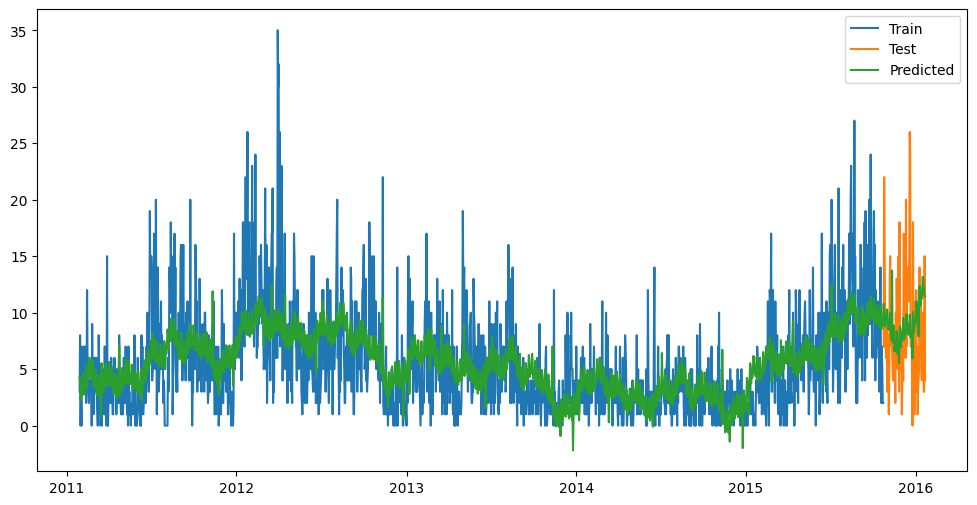

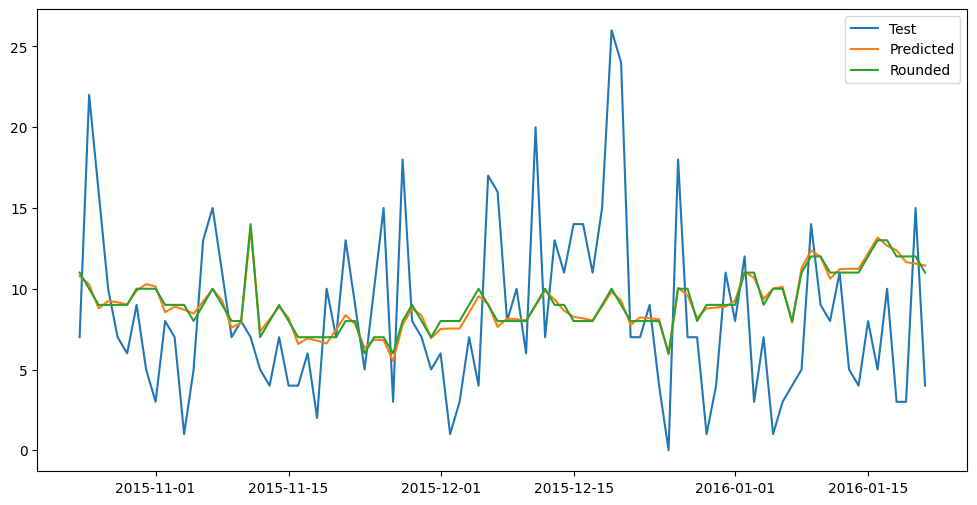

In [8]:
test_forecast = forecast.set_index('ds').loc[test['ds'], 'yhat']

test_forecast_rounded = test_forecast.round()

y_avg = test['y'].mean()

print('BARE')
mae = mean_absolute_error(test['y'], test_forecast)
print(f'MAE: {mae:.2f}')
mse = mean_squared_error(test['y'], test_forecast)
print(f'MSE: {mse:.2f}')
print(f'MAE/avg: {mae / y_avg}')

print('*' * 10)
print('ROUNDED')
mae = mean_absolute_error(test['y'], test_forecast_rounded)
print(f'MAE: {mae:.2f}')
mse = mean_squared_error(test['y'], test_forecast_rounded)
print(f'MSE: {mse:.2f}')
print(f'MAE/avg: {mae / y_avg}')

print('*' * 10)
print('За месяц:')
print('SUM test:',  test['y'].sum())
print('SUM predicted:',  test_forecast_rounded.sum())
print('SUM difference absolute', abs(test['y'].sum() - test_forecast_rounded.sum()))
print('SUM difference %',
      round(abs(test['y'].sum() - test_forecast_rounded.sum()) / test['y'].sum() * 100, 4))

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
# plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(forecast['ds'][-len(test):], forecast['yhat'][-len(test):], label='Predicted')
plt.plot(forecast['ds'][-len(test):], forecast['yhat'][-len(test):].round(), label='Rounded')
plt.legend()
plt.show()

/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/ilgiz/dev/time-hub/venv/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of 

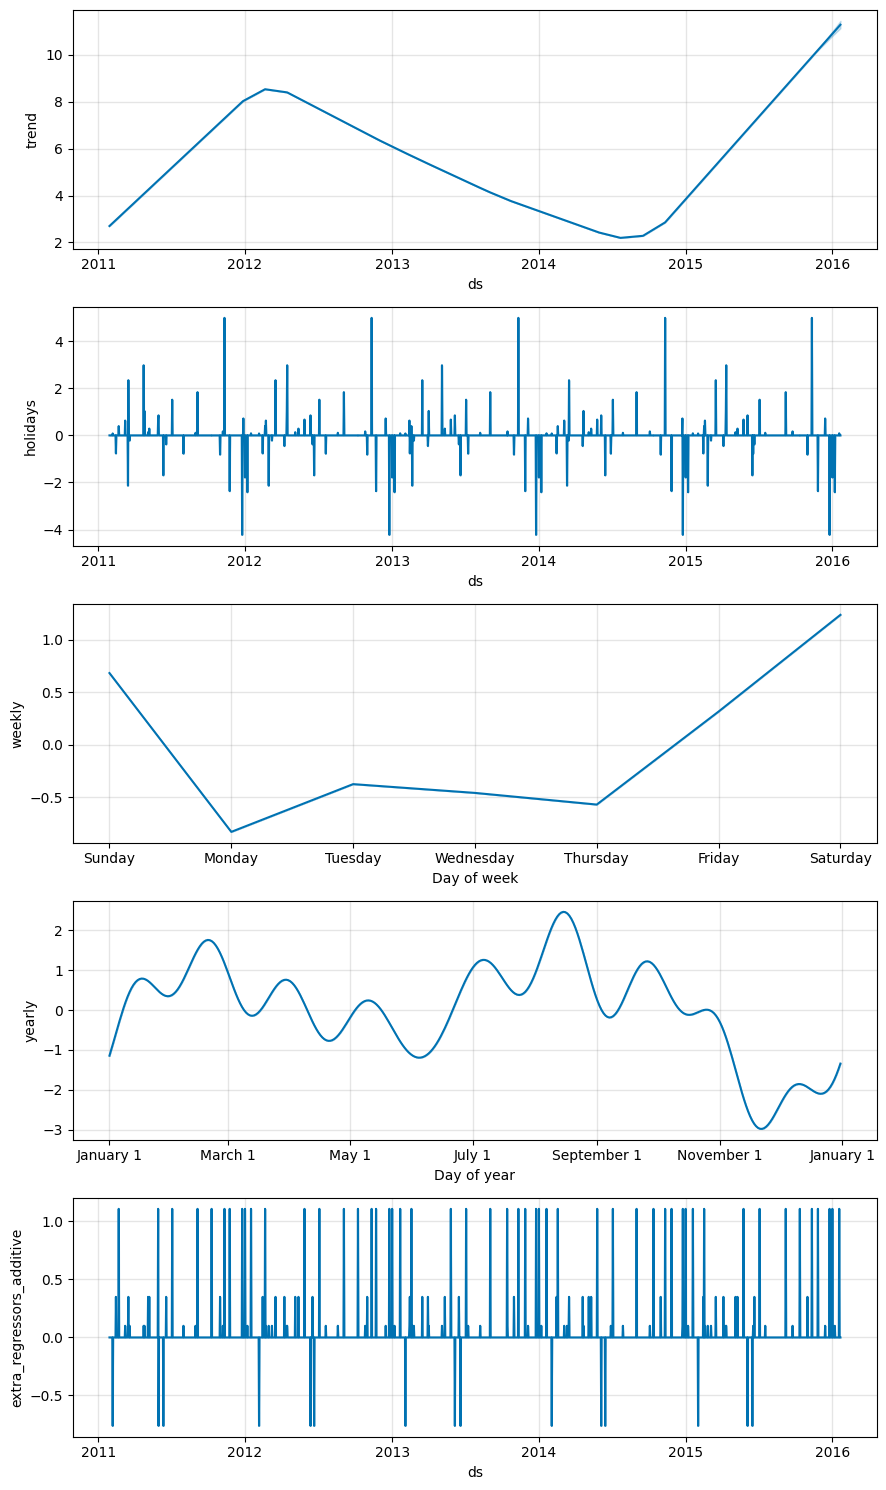

In [9]:
fig = model.plot_components(forecast)